# Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
from scipy.interpolate import interp1d
import string
from sklearn.metrics.pairwise import cosine_similarity
#from joblib import Parallel, delayed
import multiprocessing
from subprocess import Popen, PIPE, STDOUT
from multiprocessing import Process, Queue


# Global Variables

In [2]:
opts = {
    "timeseries_identifier": "id",
    "time_variable": "t",
    "value_variable": "activity",
    "r1": 1, # Interpolation resolution
    "beta": 7, # Number of discretization bins
    "l": 2, # Motif length (always 2 for this analysis)
    "resample_replications": 1000, 
    "similarity_reference_stratum": "under 18", # When plotting icons in decreasing similarity, the first displayed stratum
    "sort_icons_by_similarity": True
}

def get_opt(key):
    global opts
    return opts[key]

# Load the data

In [3]:
data = pd.DataFrame.from_csv("/home/raheleh/pauls_folder/needed_files/NHANES_preprocessed.csv", header=None, index_col=None)

In [4]:
data.columns = ["pid_contcounter", "patient_id", "t", "activity"]

In [5]:
data.set_index("patient_id", inplace=True)

In [6]:
data.sort_index(inplace=True)

In [7]:
demographics_data = pd.DataFrame.from_csv("/home/raheleh/pauls_folder/needed_files/NHANES2005_06_demographics.csv")

In [8]:
valid_patient_data = pd.DataFrame.from_csv("/home/raheleh/pauls_folder/needed_files/NHANES_valid_patients.csv")
valid_patients = valid_patient_data[valid_patient_data.valid_person == "Yes"].index

In [9]:
len(valid_patients)

10107

In [10]:
data["valid"] = valid_patient_data

In [11]:
data.drop(data["valid"] == 'No', inplace=True)

In [12]:
data.head()
data

,pid_contcounter,t,activity,valid
patient_id,,,,
21005,21005.10,1,0,No
21005,21005.10,2,0,No
21005,21005.10,3,0,No
21005,21005.10,4,0,No
21005,21005.10,5,0,No
21005,21005.10,6,0,No
21005,21005.10,7,0,No
21005,21005.10,8,0,No
21005,21005.10,9,0,No


In [13]:
import gc
gc.collect()

69

In [14]:
data.dropna(inplace=True)

In [15]:
data.reset_index(inplace=True)
data.set_index("pid_contcounter", inplace=True)

In [16]:
data.columns

Index([u'patient_id', u't', u'activity', u'valid'], dtype='object')

In [17]:
data.to_csv("/home/raheleh/pauls_folder/needed_files/data_prepared.csv")

In [18]:
patient_enum_contcounters = data.reset_index()[["pid_contcounter", "patient_id"]].drop_duplicates().set_index("patient_id")
patient_enum_contcounters

,pid_contcounter
patient_id,
21005,21005.10
21005,21005.20
21005,21005.30
21005,21005.40
21005,21005.50
21005,21005.60
21005,21005.70
21005,21005.80
21005,21005.90


In [19]:
patient_enum_contcounters.to_csv("/home/raheleh/pauls_folder/needed_files/patient_enum_contcounters.csv")

### Raw Value Histogram

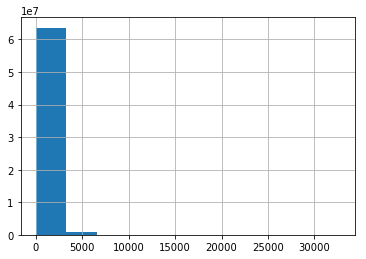

In [20]:
data[get_opt("value_variable")].hist()

# Piecewise Aggregate Approximation

In [21]:
paa = {}
frame_sizes = [78] #np.linspace(5, 200, 200 - 20).round()
frame_sizes

[78]

In [22]:
def piecewise_aggregate_approximation(time_series, r1, r2):
    time_series = pd.Series(time_series.values) #disregard indices
    d = int(time_series.count())
    w = int(np.ceil(float(r1 * (d - 1)) / float(r2)))
    # Take care of the special case where there is no dimensionality reduction
    if d == 1 or w == d:
        paa = time_series
    else:
        if d % w == 0:
            paa = time_series.reshape([d / w, w], order="F").mean(axis=0)
        else:
            try:
                temp = pd.DataFrame(time_series).T.reindex(index = xrange(w), method="ffill")
                expanded_sub_section = temp.values.reshape(w * d, order="F")
                paa = expanded_sub_section.reshape([d, w], order="F").mean(axis=0)
            except:
                print time_series
    return pd.Series(paa)

In [23]:
def parallel_paa_wrapper(vital_sign_data_grouped, r1, r2):
    vital_sign_data_grouped.apply(piecewise_aggregate_approximation, r1 = r1, r2 = r2).to_csv("/tmp/paa_progress_" + str(r2) + ".csv")
    return 1
    #return {
    #    "frame_size": r2,
    #    "results": paa_result
    #}

In [24]:
data_grouped = data[get_opt("value_variable")].groupby(level=0)

In [25]:
r2 = 78
data_grouped.apply(piecewise_aggregate_approximation, r1=1, r2=r2).to_csv("/tmp/paa_progress_" + str(r2) + ".csv")

/home/raheleh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


# Discretization

In [26]:
frame_sizes = [78] #[100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,11,120,121,122,123,124,125,126,127,128,129,12,130,131,132,133,134,135,136,137,138,139,13,140,141,142,143,144,145,146,147,148,149,14,150,151,152,153,154,155,156,157,158,159,15,160,161,162,163,164,165,166,167,168,169,16,170,171,172,173,174,175,176,177,178,179,17,180,181,182,183,184,185,186,187,188,189,18,190,191,192,193,194,195,196,197,198,199,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99]

In [27]:
from joblib import Parallel, delayed
def calculate_breakpoints(frame_size):
    print(frame_size)
    all_paa = pd.DataFrame.from_csv("/tmp/paa_progress_" + str(frame_size) + ".csv", header=None)
    all_paa.columns = ["t", "value"]
    all_paa = all_paa.value
    beta = get_opt("beta") 
    i_vals = np.arange(1, beta)
    breakpoints = [all_paa.min()] + [
        all_paa.quantile(i / float(beta))
        for i in i_vals
    ] + [np.inf]
    really_small_number = 1e-12
    for i in np.arange(1, beta):
        if breakpoints[i] <= breakpoints[i - 1]:
            if i > 1 and breakpoints[i] <= breakpoints[i - 2]:
                raise Exception("More than two adjacent bins are filled with the same value - don't know how to proceed.")
            # Fix the case where a bin contains only a single unique value by adding
            # a really small number to the lower boundary of the second bin
            # XXX: This is somewhat hacky and should be investigated if it happens to your data set
            breakpoints[i] = breakpoints[i] + really_small_number
    return breakpoints

beta = get_opt("beta")
#breakpoints = {frame_size: calculate_breakpoints(frame_size) for frame_size in frame_sizes}
breakpoints_list = Parallel(n_jobs=multiprocessing.cpu_count())(
    delayed(calculate_breakpoints)(frame_size) for frame_size in frame_sizes
)


78


In [28]:
breakpoints = {frame_size: breakpoint_array for frame_size, breakpoint_array in zip(frame_sizes, breakpoints_list)}

In [29]:
def getcut(element):
    bps = [0.0,
             61.28793618772856,
             127.77465599042856,
             200.1437768021428,
             287.5,
             411.0581335384286,
             646.907524054714,
             np.inf]
    cut = 0
    for bp in bps:
        if element >= bp:
            cut = cut + 1
        else:
            break
    return cut

In [30]:
frame_size = 78
paa = pd.DataFrame.from_csv("/tmp/paa_progress_" + str(frame_size) + ".csv", header=None)
paa.columns = ["t", "value"]
paa = paa.value
bpser = pd.Series(breakpoints[frame_size])
cuts = paa.apply(getcut)

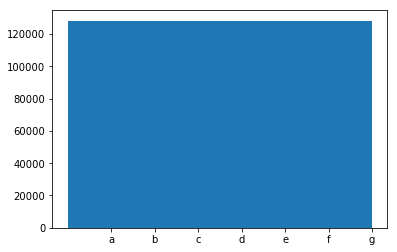

In [31]:

sax_flattened = cuts.apply(lambda cut: string.ascii_lowercase[cut - 1])
sax_words = sax_flattened.groupby(level=0).apply(lambda series: "".join(series))
letter_frequencies = sax_flattened.value_counts().sort_index()

pos = np.arange(letter_frequencies.count())
ax = plt.axes()
ax.set_xticks(pos + 0.5)
ax.set_xticklabels(letter_frequencies.index)

plt.bar(pos, letter_frequencies, width=1)
plt.show()

#return sax_words


In [32]:
sax_words = {frame_size: sax_words}
sax_words

{78: 0
 21005.10                 ae
 21005.11       ggggaacdfgge
 21005.12               fdbe
 21005.13         fegfafbaca
 21005.14       fbdgfbggfgee
 21005.20                  a
 21005.30                  f
 21005.40                  g
 21005.50                 aa
 21005.60                  b
 21005.70                  e
 21005.80                  g
 21005.90               bfge
 21006.10                 bb
 21006.20        ecbcbdegdce
 21006.30           aaaaabef
 21006.40          ffeccebfb
 21006.50            dfbccdc
 21006.60                  e
 21006.70        bdffcdfeaaa
 21006.80                  g
 21006.90    dgdccbcaaaaaaaa
 21007.10         efgggffffc
 21007.20       eccegefffgcd
 21007.30      fcgdfefedabee
 21007.40       fcefgfgdddcd
 21007.50    eccffeedecddbaa
 21007.60    aabeddggfffdfgd
 21007.70          fedfceeff
 21007.80                  g
                  ...       
 41472.40       fefffccffggf
 41472.50      fbggggdbfafcd
 41472.60           efgefdca
 41472.

### SAX Letter Histogram (Bin Counts)

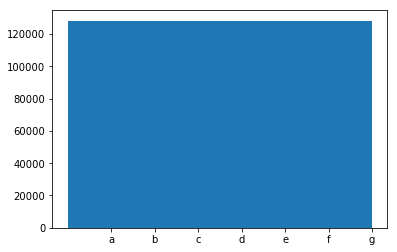

In [33]:
letter_frequencies = sax_flattened.value_counts().sort_index()

pos = np.arange(letter_frequencies.count())
ax = plt.axes()
ax.set_xticks(pos + 0.5)
ax.set_xticklabels(letter_frequencies.index)

plt.bar(pos, letter_frequencies, width=1)
plt.show()

# Identifying Motifs

In [34]:
def motif_pos(motif):
    beta = get_opt("beta")
    l = get_opt("l")
    summation = 1
    for i in range(l):
        kj = string.lowercase.index(motif[i]) + 1 # Paper is 1-based, python is 0-based
        summation = summation + (kj - 1) * beta ** (l - i - 1)
    return summation

In [35]:
def count_motifs(sax_word):
    beta = get_opt("beta")
    l = get_opt("l")
    counts = [0] * beta ** l
    for i in range(len(sax_word) - l + 1):
        motif = sax_word[i:i+l]
        m_pos = motif_pos(motif) - 1 # Paper is 1-based, python is 0-based
        counts[m_pos] = counts[m_pos] + 1
    return counts

In [36]:
def gen_motif_count_matrix(frame_size, sax_words):
    return sax_words[frame_size].apply(lambda sax_word: pd.Series(count_motifs(sax_word)))

In [103]:
motif_count_matrix = gen_motif_count_matrix(frame_size, sax_words)
motif_count_matrix

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,,,,,,,,,,,,,,,,,,,,,
21005.10,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21005.11,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,4
21005.12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21005.13,0,0,1,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
21005.14,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,2,1
21005.20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21005.30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21005.40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21005.50,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
motif_count_matrix = {78: motif_count_matrix}

In [39]:
contcounters_enum_patients = patient_enum_contcounters.reset_index().set_index("pid_contcounter")

In [40]:
motif_count_matrix_summed = {}

In [41]:
for frame_size in frame_sizes:
    motif_count_matrix_summed[frame_size] = pd.concat([contcounters_enum_patients, motif_count_matrix[frame_size]], axis=1).reset_index(drop=True).set_index("patient_id").groupby(level=0).sum()

In [42]:
motif_count_matrix_summed.keys()


[78]

# Stratification

In [43]:
def get_age_range(age):
    if age > 0 and age < 18:
        return "under 18"
    elif age >=18 and age <=24:
        return "18 - 24"
    elif age >=25 and age <=44:
        return "25 - 44"
    elif age >=45 and age <=59:
        return "45 - 59"
    elif age >=60:
        return "60+"
    else:
        return None

In [44]:
age_ranges = demographics_data["Age at Screening Adjudicated - Recode"].apply(get_age_range).dropna()



In [45]:
stratum_indexed = age_ranges
stratum_ids = stratum_indexed.groupby(level = 0).last().dropna()
strata_df = stratum_ids.reset_index()
strata_df.columns = [get_opt("timeseries_identifier"), "stratum_id"]
strata_df_indexed = strata_df.set_index("stratum_id")
strata_sizes = strata_df_indexed.groupby(level = 0).count()
unique_stratum_ids = strata_sizes.index
strata_df_indexed = strata_df_indexed.ix[unique_stratum_ids]

In [46]:
strata_sizes

,id
stratum_id,
18 - 24,1120
25 - 44,1823
45 - 59,1050
60+,1570
under 18,4259


# Identify ideal PAA resolution (not needed since we already know the best)

### Motif Importances

In [47]:
#we know this was the best
paa_frame_size = 78

In [48]:
strata_motif_importances_dict = {}
for stratum_id in unique_stratum_ids:
    member_ids = strata_df_indexed.ix[stratum_id].values.ravel()
    print(member_ids)
    motif_counts = motif_count_matrix_summed[paa_frame_size].ix[member_ids]
    motif_importances = motif_counts.sum() / motif_counts.sum().sum()
    strata_motif_importances_dict[stratum_id] = motif_importances
strata_motif_importances = pd.DataFrame.from_dict(strata_motif_importances_dict, orient = "index")

[31139 31143 31144 ..., 41465 41469 41473]
[31131 31136 31152 ..., 41440 41459 41472]
[31151 31164 31186 ..., 41458 41462 41466]
[31130 31132 31134 ..., 41461 41464 41468]
[31128 31129 31133 ..., 41467 41471 41474]


# 10 sampled groups within each againg group

In [115]:
sampled_stratum_ids=[stratum_id +"-"+str(i) for stratum_id in unique_stratum_ids for i in range(1,11) ]

sampled_stratum_ids[0]

'18 - 24-1'

In [100]:
strata_motif_importances_dict = {}
strata_motif_groupsize_dict={}
num_clusters=range(1,10)
for stratum_id in unique_stratum_ids:
    for i in range(1,11):
       member_ID=strata_df_indexed.ix[stratum_id].sample(frac=0.1, replace=False)
       tmp=member_ID.ix[:,0].values.ravel()
       l=len(tmp)
       motif_counts = motif_count_matrix_summed[paa_frame_size].ix[tmp]
       motif_importances = motif_counts.sum() / motif_counts.sum().sum()
       idx=stratum_id +"-"+str(i)
       strata_motif_importances_dict[idx] = motif_importances
       strata_motif_groupsize_dict[idx]=l
strata_motif_importances = pd.DataFrame.from_dict(strata_motif_importances_dict, orient = "index")
strata_motif_groupsize = pd.DataFrame.from_dict(strata_motif_groupsize_dict, orient = "index")
# strata_motif_importances.ix[sampled_stratum_ids[2],:]
strata_motif_groupsize.ix[sampled_stratum_ids[2]]


0    112
Name: 18 - 24-3, dtype: int64

In [101]:
transitions = []
for l1 in string.lowercase[:7]:
    for l2 in string.lowercase[:7]:
        transition = l1 + l2
        transitions.append(transition)

In [ ]:
pd.DataFrame(strata_motif_importances.values, columns = transitions)

# boostrap for sampled data

In [111]:
def ecdf(stratum_id, strata_sizes, strata_motif_importances, motif_count_matrix):
    n = get_opt("resample_replications")
    xrim_star_arr = []
    stratum_size = int(strata_motif_groupsize.ix[stratum_id])
    for i in range(n):
        Pri = np.random.choice(motif_count_matrix.index, size = stratum_size, replace = True)
        M_star = motif_count_matrix.ix[Pri]
        x_star = M_star.sum() / M_star.sum().sum()
        xrim_star_arr.append(x_star)
    xrim_star = pd.DataFrame.from_records(xrim_star_arr)
    F_hat = 1.0 / n * (xrim_star < strata_motif_importances.ix[stratum_id]).sum()
    return F_hat


In [113]:
F_hats_arr = []
for stratum_id in sampled_stratum_ids:
    print("Normalizing " + str(stratum_id))
      
    
    F_hat = ecdf(stratum_id, strata_sizes, strata_motif_importances, motif_count_matrix_summed[paa_frame_size])
       
    F_hat["stratum_id"] = stratum_id
       
    F_hats_arr.append(F_hat)
F_hats = pd.DataFrame.from_records(F_hats_arr, index = "stratum_id")


Normalizing 18 - 24-1
Normalizing 18 - 24-2
Normalizing 18 - 24-3
Normalizing 18 - 24-4
Normalizing 18 - 24-5
Normalizing 18 - 24-6
Normalizing 18 - 24-7
Normalizing 18 - 24-8
Normalizing 18 - 24-9
Normalizing 18 - 24-10
Normalizing 25 - 44-1
Normalizing 25 - 44-2
Normalizing 25 - 44-3
Normalizing 25 - 44-4
Normalizing 25 - 44-5
Normalizing 25 - 44-6
Normalizing 25 - 44-7
Normalizing 25 - 44-8
Normalizing 25 - 44-9
Normalizing 25 - 44-10
Normalizing 45 - 59-1
Normalizing 45 - 59-2
Normalizing 45 - 59-3
Normalizing 45 - 59-4
Normalizing 45 - 59-5
Normalizing 45 - 59-6
Normalizing 45 - 59-7
Normalizing 45 - 59-8
Normalizing 45 - 59-9
Normalizing 45 - 59-10
Normalizing 60+-1
Normalizing 60+-2
Normalizing 60+-3
Normalizing 60+-4
Normalizing 60+-5
Normalizing 60+-6
Normalizing 60+-7
Normalizing 60+-8
Normalizing 60+-9
Normalizing 60+-10
Normalizing under 18-1
Normalizing under 18-2
Normalizing under 18-3
Normalizing under 18-4
Normalizing under 18-5
Normalizing under 18-6
Normalizing under 

In [125]:
df=pd.DataFrame(F_hats.values, columns = transitions, index=F_hats.index)
df

,aa,ab,ac,ad,ae,af,ag,ba,bb,bc,...,fe,ff,fg,ga,gb,gc,gd,ge,gf,gg
stratum_id,,,,,,,,,,,,,,,,,,,,,
18 - 24-1,0.112,0.000,0.013,0.972,0.999,0.995,0.759,0.000,0.019,0.229,...,0.991,0.998,0.419,0.629,0.966,0.768,0.912,0.346,0.342,0.216
18 - 24-2,0.768,0.142,0.990,0.971,1.000,0.995,0.629,0.547,0.529,0.218,...,0.879,0.267,0.004,0.064,0.970,0.014,0.238,0.009,0.004,0.007
18 - 24-3,0.269,0.003,0.224,0.194,0.995,0.959,1.000,0.008,0.007,0.026,...,0.896,0.833,0.194,0.350,0.822,0.838,0.979,0.137,0.511,0.046
18 - 24-4,0.621,0.170,0.698,0.564,0.993,0.979,0.998,0.203,0.039,0.324,...,0.703,0.170,0.003,0.974,0.944,0.816,0.653,0.007,0.013,0.199
18 - 24-5,0.182,0.035,0.094,0.962,1.000,0.981,0.964,0.117,0.023,0.446,...,0.726,0.585,0.098,0.808,0.454,0.344,0.192,0.047,0.066,0.049
18 - 24-6,0.488,0.114,0.119,0.849,0.285,0.735,0.957,0.245,0.231,0.367,...,0.610,0.697,0.551,0.989,0.850,0.825,0.876,0.607,0.265,0.728
18 - 24-7,0.732,0.084,0.009,0.984,0.997,0.996,0.664,0.067,0.103,0.311,...,0.507,0.860,0.163,0.966,0.840,0.715,0.215,0.258,0.272,0.320
18 - 24-8,0.011,0.015,0.281,0.999,0.889,0.984,0.999,0.098,0.147,0.407,...,0.950,0.620,0.185,0.834,1.000,0.668,0.962,0.251,0.303,0.053
18 - 24-9,0.016,0.009,0.017,0.948,0.048,0.802,0.780,0.111,0.001,0.208,...,1.000,0.982,0.415,0.222,0.145,0.037,0.784,0.188,0.630,0.761


# Clustring

In [139]:
F_hats.index

Index([u'18 - 24-1', u'18 - 24-2', u'18 - 24-3', u'18 - 24-4', u'18 - 24-5',
       u'18 - 24-6', u'18 - 24-7', u'18 - 24-8', u'18 - 24-9', u'18 - 24-10',
       u'25 - 44-1', u'25 - 44-2', u'25 - 44-3', u'25 - 44-4', u'25 - 44-5',
       u'25 - 44-6', u'25 - 44-7', u'25 - 44-8', u'25 - 44-9', u'25 - 44-10',
       u'45 - 59-1', u'45 - 59-2', u'45 - 59-3', u'45 - 59-4', u'45 - 59-5',
       u'45 - 59-6', u'45 - 59-7', u'45 - 59-8', u'45 - 59-9', u'45 - 59-10',
       u'60+-1', u'60+-2', u'60+-3', u'60+-4', u'60+-5', u'60+-6', u'60+-7',
       u'60+-8', u'60+-9', u'60+-10', u'under 18-1', u'under 18-2',
       u'under 18-3', u'under 18-4', u'under 18-5', u'under 18-6',
       u'under 18-7', u'under 18-8', u'under 18-9', u'under 18-10'],
      dtype='object', name=u'stratum_id')

In [141]:
type(sampled_stratum_ids)

list

# AgglomerativeClustring

In [180]:
# I think we need to make a test part for data set and then try to make classification based on similarity scores between 
# the test set and each of the groups, in the case we have lables. If the claim is we have already modeled the pdf of
# the data sets at hand. 
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
# Affinity = {“euclidean”, “l1”, “l2”, “manhattan”,
# “cosine”}
# Linkage = {“ward”, “complete”, “average”}
X=df
agg_cluster = AgglomerativeClustering(n_clusters=5,
 affinity="cosine", linkage="average")
agg_labels = agg_cluster.fit_predict(X,y=None)
agg_labels


array([1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2])

# Dendrogram

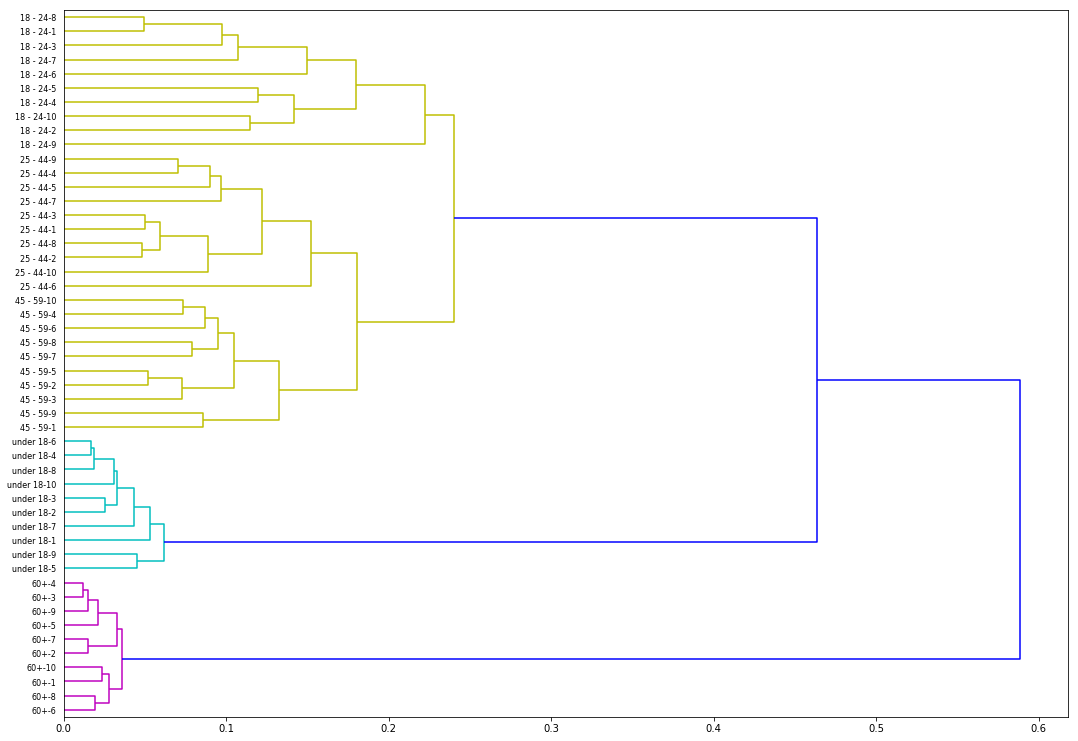

In [181]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
#scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean')[source]
Z = hierarchy.linkage(df, method="average",metric='cosine')
plt.figure(figsize=(18, 13))
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k','r'])
dn = hierarchy.dendrogram(Z,orientation='right',labels=sampled_stratum_ids)

# Now plot in given axes, improve the color scheme and use both vertical and
# horizontal orientations:
#fig, axes = plt.subplots(1, 2, figsize=(18, 13))
#dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                          # orientation='top')
#dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
 #                          orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

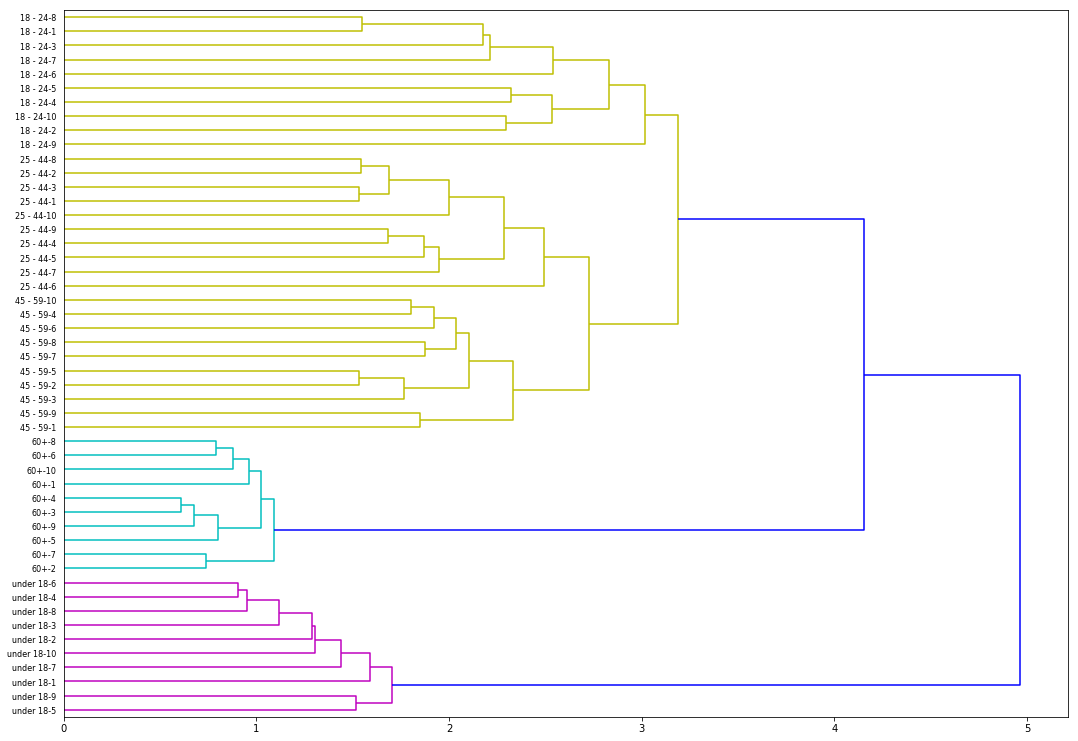

In [177]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
#scipy.cluster.hierarchy.linkage(y, method='single', metric='euclidean')[source]
Z = hierarchy.linkage(df, method="average",metric='euclidean')
plt.figure(figsize=(18, 13))
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k','r'])
dn = hierarchy.dendrogram(Z,orientation='right',labels=sampled_stratum_ids)

# Now plot in given axes, improve the color scheme and use both vertical and
# horizontal orientations:
#fig, axes = plt.subplots(1, 2, figsize=(18, 13))
#dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',
                          # orientation='top')
#dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',
 #                          orientation='right')
hierarchy.set_link_color_palette(None)  # reset to default after use
plt.show()

In [ ]:
reference_stratum = get_opt("similarity_reference_stratum")
similarities = pd.Series(cosine_similarity(X = F_hats.ix[reference_stratum], 
                                           Y = F_hats).ravel(), 
                         index = F_hats.index)

ms = np.column_stack((ground_truth,Hclustering.labels_))
df = pd.DataFrame(ms,
 columns = [‘Ground truth’,’Clusters’])
pd.crosstab(df[‘Ground truth’], df[‘Clusters’],
 margins=True)

# bootstrap for Original data groups

In [116]:
def ecdf(stratum_id, strata_sizes, strata_motif_importances, motif_count_matrix):
    n = get_opt("resample_replications")
    xrim_star_arr = []
    stratum_size = int(strata_sizes.ix[stratum_id])
    for i in range(n):
        Pri = np.random.choice(motif_count_matrix.index, size = stratum_size, replace = True)
        M_star = motif_count_matrix.ix[Pri]
        x_star = M_star.sum() / M_star.sum().sum()
        xrim_star_arr.append(x_star)
    xrim_star = pd.DataFrame.from_records(xrim_star_arr)
    F_hat = 1.0 / n * (xrim_star < strata_motif_importances.ix[stratum_id]).sum()
    return F_hat

In [117]:
F_hats_arr = []
for stratum_id in unique_stratum_ids:
    for i in range(1,11):
        idx=stratum_id +"-"+str(i)
        print("Normalizing " + str(stratum_id))
      
    
        F_hat = ecdf(stratum_id, strata_sizes, strata_motif_importances, motif_count_matrix_summed[paa_frame_size])
       
        F_hat["stratum_id"] = stratum_id
       
        F_hats_arr.append(F_hat)
F_hats = pd.DataFrame.from_records(F_hats_arr, index = "stratum_id")


Normalizing 18 - 24


KeyError: '18 - 24'

In [475]:
pd.DataFrame(F_hats.values, columns = transitions, index=F_hats.index)

,aa,ab,ac,ad,ae,af,ag,ba,bb,bc,...,fe,ff,fg,ga,gb,gc,gd,ge,gf,gg
stratum_id,,,,,,,,,,,,,,,,,,,,,
18 - 24,0.011,0.000,0.183,1.000,1.000,1.000,1.0,0.000,0.000,0.355,...,1.0,0.886,0.000,0.999,0.999,0.205,0.137,0.0,0.000,0.000
25 - 44,0.000,0.000,0.001,0.924,0.996,0.773,0.0,0.000,0.000,0.210,...,1.0,1.000,0.252,0.000,0.000,0.000,0.000,0.0,0.502,0.039
45 - 59,0.000,0.391,0.996,0.986,0.888,0.590,0.0,0.547,0.972,0.999,...,1.0,1.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
60+,1.000,1.000,1.000,1.000,0.054,0.000,0.0,1.000,1.000,1.000,...,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
under 18,0.000,0.000,0.000,0.000,0.000,1.000,1.0,0.000,0.000,0.000,...,1.0,1.000,1.000,1.000,1.000,1.000,1.000,1.0,1.000,1.000


# Strata Similarities

In [476]:
reference_stratum = get_opt("similarity_reference_stratum")
similarities = pd.Series(cosine_similarity(X = F_hats.ix[reference_stratum], 
                                           Y = F_hats).ravel(), 
                         index = F_hats.index)

/home/raheleh/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


# Icons

/home/raheleh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
/home/raheleh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:28: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


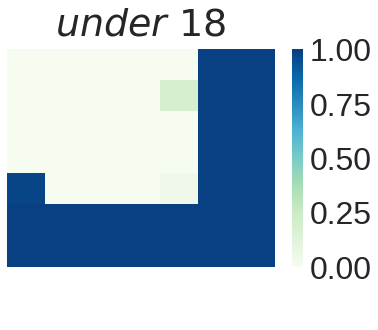

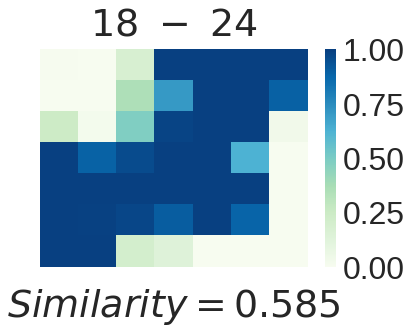

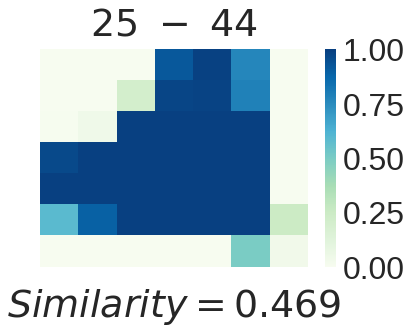

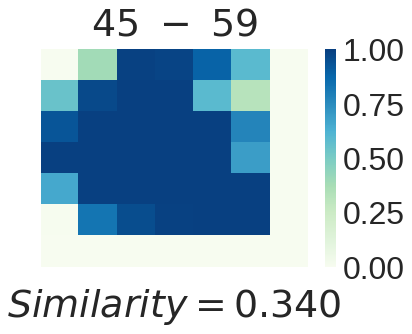

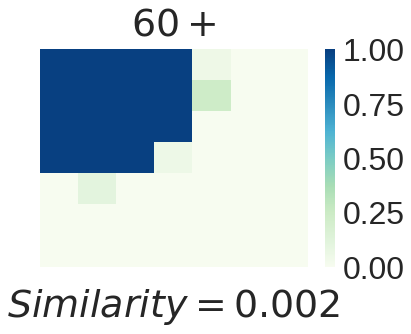

In [477]:
reference_stratum = get_opt("similarity_reference_stratum")
sort_by_similarity = get_opt("sort_icons_by_similarity")
show_icon_similarities = True

if sort_by_similarity:
    similarities.sort(ascending = False)
    strata_sorted = similarities.index
else:
    #sort lexicographically by stratum id
    strata_sorted = similarities.sort_index().index
    
for stratum_id in strata_sorted:
    icon = F_hats.ix[stratum_id]
    beta = get_opt("beta")
    icon_side = beta

    ax = plt.axes()
    #hide distracting axis ticks
    ax.tick_params(labelbottom='off',
                   labelleft='off')
    ax.set_title(label="$" + string.replace(string.replace(str(stratum_id), ' ', '\ '), "_", "\_") + "$", fontsize=38, y=1.04)
    similarity = similarities[stratum_id]
    if stratum_id != reference_stratum and show_icon_similarities:
        ax.set_xlabel(xlabel=r"$Similarity = " + ('%.3f' % similarity) + "$", \
                      fontsize=38, labelpad = 20)
    else:
        #placeholder label so icon sets can be neatly shown next to each other
        ax.set_xlabel(xlabel=r"a", color="white", fontsize=38, labelpad = 20)
    pixel_data = icon.reshape([icon_side, icon_side]).astype(float)
    heatmap = ax.pcolor(pixel_data, cmap = plt.get_cmap("GnBu"))
    ax.invert_yaxis()
    cbar = plt.colorbar(heatmap, ax=ax)
    cbar.ax.tick_params(labelsize=32)
    cbar.set_ticks(np.linspace(0, 1, 5))
    plt.show()
    